**Authors:**  Kleanthis Karamvasis <br>
**Copyright:** 2024 Kleanthis Karamvasis <br>
**License:** GPLv3

<div class="alert alert-block alert-success">
<h3>FLOODPY: Mapping flooded regions of Daniel Flood event Greece, September 2023 </h3></div>

<div class="alert alert-block alert-warning">

### Important:
<font size="3"> Before running this notebook, please make sure that 
1. you have successufully <b>created</b> floodpy_gpu conda environment based on [FLOODPY_gpu_env](FLOODPY_gpu_env.yml)
2. you have <b>activated</b> the floodpy_gpu conda environment for running this notebook 
3. you have downloaded Floodvit model from https://www.dropbox.com/scl/fi/srw7u4cw1gtxrf4xzmsh7/floodvit.pt?rlkey=snskpq1qrdav5u2jya8k2bocg&e=1&dl=0
</font>
</div>

# NOTEBOOK INTRODUCTION

### Data used

| Product Name | Description | Usage | Access Link |
|:--------------------:|:-----------------:|:-----------------:|:-----------------:|
| ERA5 | ERA5 is the fifth generation ECMWF reanalysis for the global climate and weather for the past 4 to 7 decades. ERA5 provides hourly estimates for a large number of atmospheric, ocean-wave and land-surface quantities. Data has been regridded to a regular lat-lon grid of 0.25 degrees for the reanalysis. ERA5 is updated daily with a latency of about 5 days. | Precipitation | <a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels" target="_blank">link</a> |
| Sentinel-1 GRD | The Sentinel-1 mission comprises a constellation of two polar-orbiting satellites, operating day and night performing C-band synthetic aperture radar imaging, enabling them to acquire imagery regardless of the weather. | Backscatter changes | <a href="https://dataspace.copernicus.eu/" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will be able to identify flooded regions from Sentinel-1 data using FloodPy. Be aware that the estimated run time of the notebook depends on your **area of interest**, your **temporal span of interest** and your network **download speed**.

### Outline
<font size="3">
Floods are considered the second gravest disaster for the agricultural sector. The increasing intensity and the frequency of flood events can result to significant yield losses. In the present notebook, we present a <b>ViT-based (Visual Transformer) approach</b> (Bountos et al., 2023) to extract flooded area based on multitemporal Sentinel-1 intensity observations.
<br>
    
The FLOODPY - <b>FLOOD PYthon toolbox</b> is a free and open-source python toolbox for mapping of floodwater. FLOODPY requires a specified time of interest related to the flood event and corresponding geographical boundaries. We believe that the produced maps with delineated flood-affected agricultural fields can be helpful for governments, insurers and disaster response agencies to improve flood risk assessment, relief targeting, and ultimately to protect climate-vulnerable communities from floods. 

References:

<font size="2">
    
Bountos, N. I., Sdraka, M., Zavras, A., Karasante, I., Karavias, A., Herekakis, T., ... & Papoutsis, I. (2023). Kuro Siwo: 12.1 billion $ m^ 2$ under the water. A global multi-temporal satellite dataset for rapid flood mapping. arXiv preprint [paper link](https://arxiv.org/abs/2311.12056) [github link](https://github.com/Orion-AI-Lab/KuroSiwo)


<div class="alert alert-info" role="alert">
    
## <a id='TOC_TOP'></a>Contents

</div>
    
[1. Flood event description](#section1)

[2. Set input arguments for FLOODPY](#section2)

[3. Estimation of Flooded Area](#section3)

[4. Interactive Plotting](#section4)

<hr>

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Flood event description
[Back to top](#TOC_TOP)

</div>


In September 2023 large areas in the Mediterranean were affected by Storm Daniel. On 5-7 September 2023 Thessaly experienced extreme rainfall followed by extensive floods, resulting in the loss of human lives, livestock, harvests, land and assets. The flooding was a sudden-onset event as the floods occurred very fast.

More information: https://european-flood.emergency.copernicus.eu/en/news/storm-daniel-affects-greece-bulgaria-and-turkiye-september-2023 



<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Set input parameters for FLOODPY
[Back to top](#TOC_TOP)

</div>


In [1]:
# The path of your project. Make sure you have enough free space disk on the specific location.
projectfolder = '/home/kleanthis/Projects/Thessalia_Floods_2023'

# Please provide a description of the flood event (e.g. Thessalia September 2023)
flood_event = 'Thessalia September 2023'

# The location of floodpy code 
src_dir = '/home/kleanthis/Projects/FLOODPY/floodpy/'

# SNAP ORBIT DIRECTORY
snap_orbit_dir = '/home/kleanthis/.snap/auxdata/Orbits/Sentinel-1'

# SNAP GPT full path
GPTBIN_PATH = '/home/kleanthis/snap9/bin/gpt'

# The start and end datetimes for Pre-flood time span and flood time span (Format is YYYYMMDDTHHMMSS in UTC)
pre_flood_start = '20230803T030000'
pre_flood_end = '20230903T030000'
flood_start = '20230903T030000'
flood_end = '20230919T030000'

# Flood event spatial information 
# - You can provide AOI VECTOR FILE or AOI BBOX. 
# - Please ensure that your AOI BBOX has dimensions smaller than 100km x 100km
# - If you provide AOI VECTOR, AOI BBOX parameters will be ommited
# - In case you provide AOI BBOX coordinates, set  AOI_File = None

# AOI VECTOR FILE (if given AOI BBOX parameters can be ommited)
AOI_File = "None"

# AOI BBOX (WGS84)
LONMIN = 21.82
LATMIN = 39.35
LONMAX = 22.30
LATMAX = 39.65

# Data access and processing
# The number of Sentinel-1 relative orbit. The default 
#       value is Auto. Auto means that the relative orbit that has
#       the Sentinel-1 image closer to the Flood_datetime is selected. 
#       S1_type can be GRD or SLC.
relOrbit = 'Auto' 

# The minimum mapping unit area in square meters
minimum_mapping_unit_area_m2=4000

# Computing resources to employ
CPU=8
RAM='20G'

# Credentials for Sentinel-1/2 downloading
Copernicus_username = 'Floodmappingteam@gmail.com'
Copernicus_password = '!!2024Floodpy'

<div class="alert alert-block alert-warning">

#### Important: <font size="3"> Please provide the path of the Floodvit model [link](https://www.dropbox.com/scl/fi/srw7u4cw1gtxrf4xzmsh7/floodvit.pt?rlkey=snskpq1qrdav5u2jya8k2bocg&e=1&dl=0)</font></div>

In [2]:
ViT_model_filename = '/home/kleanthis/Projects/Thessalia_Floods_2023/Vit_model/floodvit.pt'

In [3]:
params_dict = {'projectfolder':projectfolder,
               'flood_event':flood_event,
                'src_dir' : src_dir,
                'snap_orbit_dir' : snap_orbit_dir,
                'GPTBIN_PATH' : GPTBIN_PATH,
                'pre_flood_start' : pre_flood_start,
                'pre_flood_end' : pre_flood_end,
                'flood_start' : flood_start,
                'flood_end' : flood_end,
                'AOI_File' : AOI_File,
                'LONMIN' : LONMIN,
                'LATMIN' : LATMIN,
                'LONMAX' : LONMAX,
                'LATMAX' : LATMAX,
                'relOrbit' : relOrbit,
                'minimum_mapping_unit_area_m2' : minimum_mapping_unit_area_m2,
                'CPU' : CPU,
                'RAM' : RAM,
                'Copernicus_username' : Copernicus_username,
                'Copernicus_password' : Copernicus_password,
            }

<div class="alert alert-info" role="alert">

## <a id='section2'></a>3. Estimation of Flooded Area using Sentinel-1 data
[Back to top](#TOC_TOP)
</div>

### <a id='search_download'></a> Insert Python Modules

In [5]:
import pandas as pd
import copy

# FLOODPY libraries
from floodpy.FLOODPYapp import FloodwaterEstimation
from floodpy.Visualization.interactive_plotting import plot_interactive_map
from floodpy.Visualization.flood_over_time import plot_flooded_area_over_time

### <a id='search_download'></a> Start up

In [6]:
Floodpy_app = FloodwaterEstimation(params_dict = params_dict)

### Download Landcover

In [7]:
Floodpy_app.download_landcover_data()

### <a id='search_download'></a> Downloading Precipitation from ERA5 model


In [8]:
Floodpy_app.download_ERA5_Precipitation_data()

Precipitation data can be found at /home/kleanthis/Projects/Thessalia_Floods_2023/ERA5


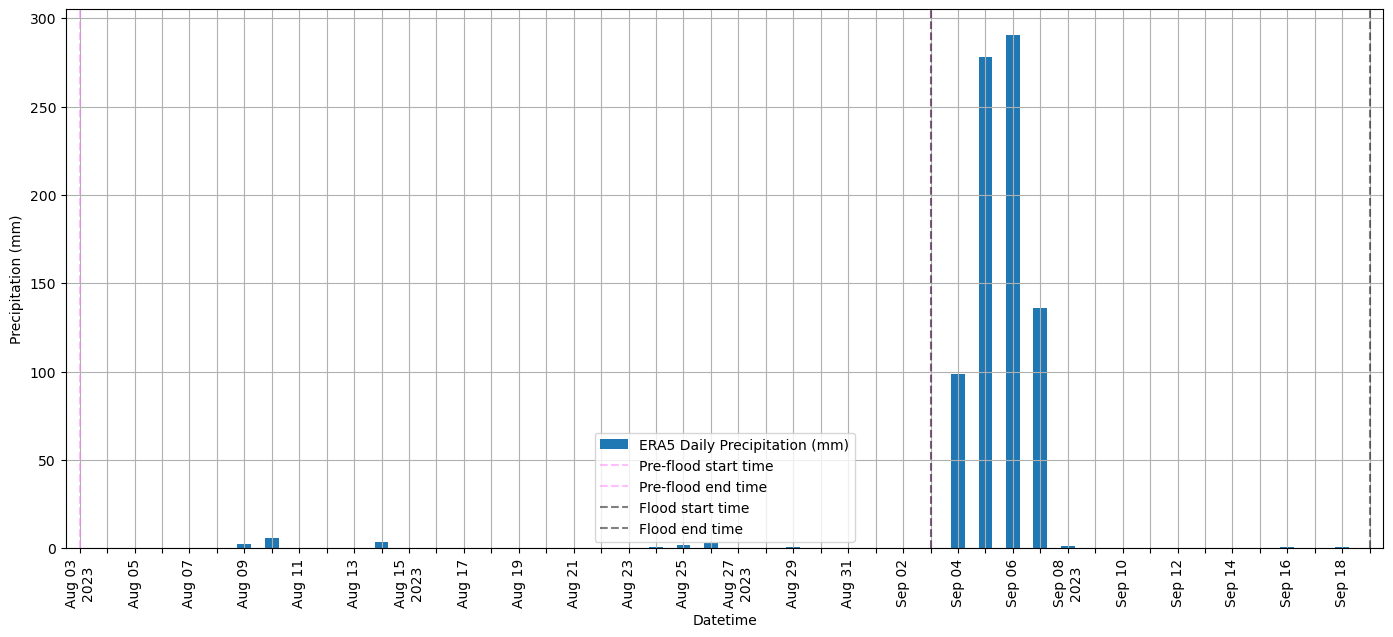

In [9]:
Floodpy_app.plot_ERA5_precipitation_data()

### <a id='search_download'></a> Download Sentinel-1 data

In [10]:
Floodpy_app.query_S1_data()
print('The available dates for flood mapping are: \n --> {}'.format('\n --> '.join(map(str, Floodpy_app.flood_datetimes))))

The available dates for flood mapping are: 
 --> 2023-09-06 04:39:47.095652
 --> 2023-09-07 16:24:12.139701
 --> 2023-09-12 16:32:24.059385
 --> 2023-09-13 04:31:57.827516
 --> 2023-09-18 04:39:47.608904


### Calculate flooded regions

In [11]:
print('The flooded region for the following datetimes will be calculated:')
print(*list(Floodpy_app.flood_datetimes),sep='\n')

The flooded region for the following datetimes will be calculated:
2023-09-06 04:39:47.095652
2023-09-07 16:24:12.139701
2023-09-12 16:32:24.059385
2023-09-13 04:31:57.827516
2023-09-18 04:39:47.608904


In [ ]:
# You can also select specific flood dates following the example:
# Example --> 

# Floodpy_app.flood_datetimes = [pd.Timestamp('2023-09-13 04:31:57.827516'),
#                                pd.Timestamp('2023-09-07 16:24:12.139701')]

Floodpy_app_objs = {}
for flood_date in Floodpy_app.flood_datetimes:
    Floodpy_app.sel_S1_data(flood_date)
    Floodpy_app.download_S1_GRD_products()
    Floodpy_app.download_S1_orbits()
    Floodpy_app.create_S1_stack(overwrite=False)
    Floodpy_app.calc_flooded_regions_ViT(ViT_model_filename = ViT_model_filename,
                                         device = 'cuda',
                                         generate_vector = True,
                                         overwrite = False)
    Floodpy_app_objs[flood_date] = copy.deepcopy(Floodpy_app)
    

### Plot area of flooded regions over time

The figure can be found at: /home/kleanthis/Projects/Thessalia_Floods_2023/Results/Thessalia September 2023.svg


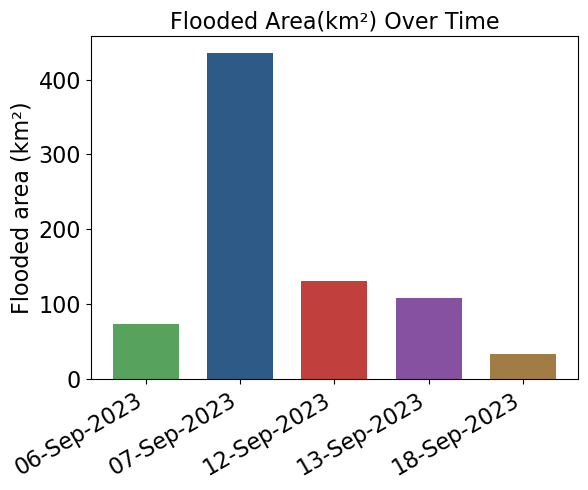

In [13]:
plot_flooded_area_over_time(Floodpy_app, Floodpy_app_objs)

### Select a single datetime for Interactive plotting

In [14]:
print("Select a singe datetime for the following list:")
print(*list(Floodpy_app_objs.keys()),sep='\n')

Select a singe datetime for the following list:
2023-09-06 04:39:47.095652
2023-09-07 16:24:12.139701
2023-09-12 16:32:24.059385
2023-09-13 04:31:57.827516
2023-09-18 04:39:47.608904


In [ ]:
# Example: plot_interactive_map(Floodpy_app_objs[pd.Timestamp('This should be replaced')])
plot_interactive_map(Floodpy_app_objs[pd.Timestamp('2023-09-07 16:24:12.139701')])